In [1]:
import numpy as np
from scipy.integrate import odeint
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from sympy import solve, Poly, Eq, Function, exp, symbols, lambdify


import matplotlib.pyplot as plt
%matplotlib inline

# Photosynthesis models

In [2]:
t = np.linspace(0, 0.2, 10000)
sa = 1.33 #section d'absorption
tf = 1e-12
ks = 1e5
I = 1000 #intensite

k1 =  tf*ks/(1+tf*ks)#fluo

k2 = 3.4e6
k3 = 1.56e5
km3 = 3.12e4
k4 = 50.0
X = 17.5
D = 2.5

y0 = [D, 0, 0, X]

### Modèle Ludovic

$y = [A, B, C, P]$

On introduit $k_1 = \frac{k_s \tau_F}{1 + k_s \tau_F}\sigma I$


(a) $\frac{\partial [A_1]}{\partial t} = - k_1[A_1] + k_3^+[A_3][P] - k_3^-[A_1](X-[P])$  
(b) $\frac{\partial [A_2]}{\partial t} = k_1[A_1] - k_2[A_2]$  
(c) $\frac{\partial [A_3]}{\partial t} = k_2[A_2] - k_3^+[A_3][P] + k_3^-[A_1](X-[P])$   
(d) $\frac{\partial [P]}{\partial t} = - k_3^+[A_3][P] + k_3^-[A_1](X-[P]) + k_4(X-[P])$   
(e) $D = [A_1] + [A_2] + [A_3]$  


In [3]:
def system_direct(y, t, sa, I, k2, km3, k3, k4, k1, X, D):
    sens_plus = k3 * y[2] * y[3]
    sens_moins = km3* y[0]*(X-y[3])
    chaine = k4 * (X - y[3])
    excitation = sa* I * k1 * (D - y[1] - y[2])
    reduction_eau = k2 * y[1]
    dA = -excitation + sens_plus - sens_moins
    dB = excitation  - reduction_eau
    dC = - sens_plus + sens_moins + reduction_eau
    dP = -sens_plus + sens_moins + chaine
    return [dA, dB, dC, dP]


### Modèle inverse

(a) $\frac{\partial [A_1]}{\partial t} = - k_1[A_1] + k_2[A_2]$  
(b) $\frac{\partial [A_3]}{\partial t} = k_1[A_1] - k_3^+[A_3][P] + k_3^-[A_2](X-[P])$  
(c) $\frac{\partial [A_2]}{\partial t} = -k_2[A_2] + k_3^+[A_3][P] - k_3^-[A_2](X-[P])$   
(d) $\frac{\partial [P]}{\partial t} = - k_3^+[A_3][P] + k_3^-[A_2](X-[P]) + k_4(X-[P])$   
(e) $D = [A_1] + [A_2] + [A_3]$  


In [4]:
def system_inverse(y, t, sa, I, k2, km3, k3, k4, k1, X, D):
    sens_plus = k3 * y[2] * y[3]
    sens_moins = km3* y[0]*(X-y[3])
    chaine = k4 * (X - y[3])
    excitation = sa* I * k1 * (D - y[1] - y[2])
    reduction_eau = k2 * y[1]
    dA = -excitation + reduction_eau
    dB = excitation  - sens_plus + sens_moins
    dC =  sens_plus - sens_moins - reduction_eau
    dP = -sens_plus + sens_moins + chaine
    return [dA, dB, dC, dP]


In [5]:

#yout = odeint(system_inverse, y0, t, args = (sa, I, k2, km3, k3, k4, k1, X, D))  # EXERCISE: rhs, y0, tout, k_vals
#plt.plot(t, yout)
#_ = plt.legend(['A', 'B', 'C', 'P'])

Text(0, 0.5, '[P680*]')

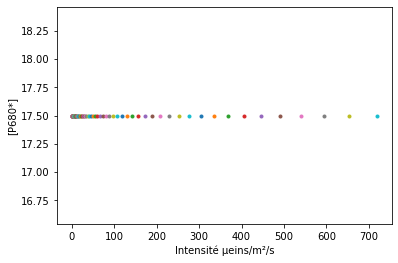

In [14]:
for i in range(0,70):
    I = 1.1**i
    k_fact = sa*I*k1
    yout = odeint(system_direct, y0, t, args = (sa, I, k2, km3, k3, k4, k1, X, D))  # EXERCISE: rhs, y0, tout, k_vals
    #plt.plot(t, yout[:,1], label = 2**i)
    A1 = yout[0][-1]
    plt.plot(I, A1, '.')
plt.xlabel("Intensité µeins/m²/s")
plt.ylabel("[P680*]")
#plt.legend()

In [85]:
len(I*k_fact*A1)

10000

# Model Ebenhoh + fluo

In [15]:
ks = symbols('k_s')
tf = symbols('t_f')
k2 = symbols('k_2')
s = symbols('\sigma')
I = symbols('I')
k3p = symbols('k_3^+')
k3m = symbols('k_3^-')
k4 = symbols('k_4')
D = symbols('D')
X = symbols('X')
P = symbols("P")

k1 = s*I*(ks*tf/(1 + ks*tf))
alpha = k3p *k4 *(1/k1 + 1/k2)
beta = k3m*k4/k1
[u, v] = solve(P**2*(alpha-beta) + P*(k3p*D - alpha * X + 2*beta*X - k4) - beta*X**2 - k4*X, P)
model = lambdify([ks, tf, k2, s, k3p, k3m, I, k4, D, X], v)
def model_ludovic(ks, tf, k2, s, k3p, k3m, k4, D, X):
    val_I = 10**np.linspace(0, 5, 1000)
    P_concentration = model(10**ks, 10**-tf, 10**k2, 10**s, 10**k3p, 10**k3m, val_I, 10**k4, 10**D, X)
    print(P_concentration.max())
    plt.plot(val_I, val_I*(P_concentration.max() - P_concentration))
    plt.show()

In [16]:
v.subs({ks:1e5, tf:1e-12, k2:1e5,s:1.3,k3p:1e5,k3m:1e5,k4:1e5,D:10,X:10})

0.000384615384615385*(1300.0*I + 1.0000001e+16*sqrt(6.92899861420021e-25*I**2 + 4.93999950600005e-12*I + 1) - 1.0000001e+16)/I

In [7]:
#interact(model_ludovic, ks = (0, 6), tf = (8, 15), k2 = (0, 6), s = (0, 6), k3p = (0, 6), k3m = (0, 6), k4 = (0, 6), D = (0, 6), X = (0, 6))



# Model Ebenhoh inversé

In [17]:
ks = symbols('k_s')
tf = symbols('t_f')
k2 = symbols('k_2')
s = symbols('\sigma')
I = symbols('I')
k3p = symbols('k_3^+')
k3m = symbols('k_3^-')
k4 = symbols('k_4')
D = symbols('D')
X = symbols('X')
P = symbols("P")

k1 = s*I*(ks*tf/(1 + ks*tf))
alpha = k3p *k4 *(1/k1 + 1/k2)
beta = k3m*k4/k2
[u, v2] = solve(P**2*(alpha-beta) + P*(k3p*D - alpha * X + 2*beta*X - k4) - beta*X**2 - k4*X, P)
model2 = lambdify([ks, tf, k2, s, k3p, k3m, I, k4, D, X], v2)
def model_inverse(ks, tf, k2, s, k3p, k3m, k4, D, X):
    val_I = 10**np.linspace(0, 5, 1000)
    P_concentration = model2(10**ks, 10**-tf, 10**k2, 10**s, 10**k3p, 10**k3m, val_I, 10**k4, 10**D, X)
    print(P_concentration.max())
    plt.plot(val_I, val_I*(P_concentration.max() - P_concentration))
    plt.show()

In [18]:
v2.subs({ks:1e5, tf:1e-12, k2:1e5,s:1.3,k3p:1e5,k3m:1e5,k4:1e5,D:10,X:10})

-1.23499987650001e-11*I + 5.0*sqrt(6.10089877982018e-24*I**2 + 7.79999922000008e-13*I + 1) + 5.0

In [10]:
#interact(model_inverse, ks = (0, 6), tf = (8, 15), k2 = (0, 6), s = (0, 6), k3p = (0, 6), k3m = (0, 6), k4 = (0, 6), D = (0, 6), X = (0, 6))


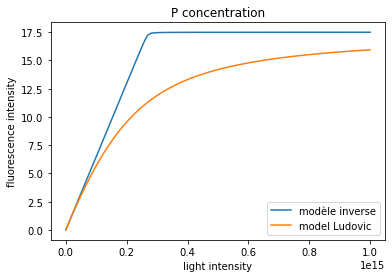

In [19]:
ks = 1e3
tf = 1e-15
k2 = 3e6
s = 1.3
k3p = 1e5
k3m = 3e4
k4 = 50
X = 17.5
D = 2.5
#k1 = s*I*(ks*tf/(1 + ks*tf))
v2.subs({ks:ks, tf:tf, k2:k2,s:s,k3p:k3p,k3m:k3m,k4:k4,D:D,X:X})
val_I = 10**np.linspace(0, 15, 1000)

P_concentration2 = model2(ks,tf, k2, s, k3p, k3m, val_I, k4, D, X)
plt.plot(val_I, (P_concentration2.max() - P_concentration2), label = "modèle inverse")
P_concentration = model(ks,tf, k2, s, k3p, k3m, val_I, k4, D, X)
plt.plot(val_I, (P_concentration.max() - P_concentration), label = "model Ludovic")
plt.xlabel("light intensity")
plt.ylabel('fluorescence intensity')
plt.title("P concentration")
plt.legend()

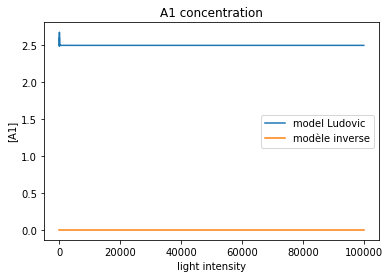

In [21]:
val_I = 10**np.linspace(0, 5, 1000)
P_concentration = model(ks,tf, k2, s, k3p, k3m, val_I, k4, D, X)

A1_1 = k4/(s*val_I*ks*tf/(1 + ks*tf))*(X-P_concentration)
plt.plot(val_I, A1_1, label = "model Ludovic")

P_concentration2 = model2(ks,tf, k2, s, k3p, k3m, val_I, k4, D, X)

A1_2 = k4/k2*(X-P_concentration2)
plt.plot(val_I, A1_2, label = "modèle inverse")
plt.xlabel("light intensity")
plt.ylabel('[A1]')
plt.title("A1 concentration")
plt.legend()

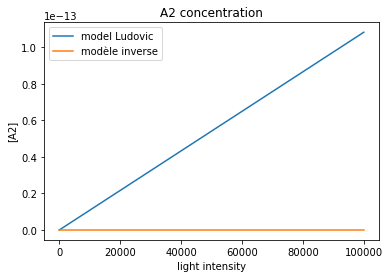

In [22]:
val_I = 10**np.linspace(0, 5, 1000)
P_concentration = model(ks,tf, k2, s, k3p, k3m, val_I, k4, D, X)
A1_1 = k4/(s*val_I*ks*tf/(1 + ks*tf))*(X-P_concentration)

A2_1 = (s*val_I*ks*tf/(1 + ks*tf))/k2*A1_1
plt.plot(val_I, A2_1, label = "model Ludovic")
P_concentration2 = model2(ks,tf, k2, s, k3p, k3m, val_I, k4, D, X)
A1_2 = k4/k2*(X-P_concentration2)

A2_2 = (s*val_I*ks*tf/(1 + ks*tf))/k2*A1_2
plt.plot(val_I, A2_2, label = "modèle inverse")
plt.xlabel("light intensity")
plt.ylabel('[A2]')
plt.title("A2 concentration")
plt.legend()

<ipython-input-23-6cf08a2133a8>:3: RuntimeWarning: divide by zero encountered in true_divide
  A1_1 = k4/(s*val_I*ks*tf/(1 + ks*tf))*(X-P_concentration)
<ipython-input-23-6cf08a2133a8>:5: RuntimeWarning: invalid value encountered in multiply
  A2_1 = (s*val_I*ks*tf/(1 + ks*tf))/k2*A1_1


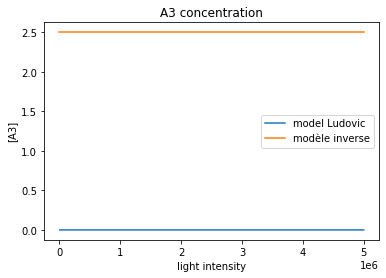

In [23]:
val_I = np.linspace(0, 5000000, 1000)
P_concentration = model(ks,tf, k2, s, k3p, k3m, val_I, k4, D, X)
A1_1 = k4/(s*val_I*ks*tf/(1 + ks*tf))*(X-P_concentration)

A2_1 = (s*val_I*ks*tf/(1 + ks*tf))/k2*A1_1
plt.plot(val_I, D-A2_1-A1_1, label = "model Ludovic")
P_concentration2 = model2(ks,tf, k2, s, k3p, k3m, val_I, k4, D, X)
A1_2 = k4/k2*(X-P_concentration2)

A2_2 = (s*val_I*ks*tf/(1 + ks*tf))/k2*A1_2
plt.plot(val_I, D-A1_2-A2_2, label = "modèle inverse")
plt.xlabel("light intensity")
plt.ylabel('[A3]')
plt.title("A3 concentration")
plt.legend()

<ipython-input-27-03f224ec657a>:3: RuntimeWarning: divide by zero encountered in true_divide
  A1_1 = k4/(s*val_I*ks*tf/(1 + ks*tf))*(X-P_concentration)
<ipython-input-27-03f224ec657a>:5: RuntimeWarning: invalid value encountered in multiply
  A1s_1 = s*val_I*ks*tf/(1 + ks*tf)*A1_1


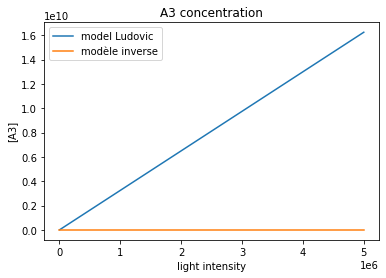

In [27]:
val_I = np.linspace(0, 5000000, 1000)
P_concentration = model(ks,tf, k2, s, k3p, k3m, val_I, k4, D, X)
A1_1 = k4/(s*val_I*ks*tf/(1 + ks*tf))*(X-P_concentration)

A1s_1 = s*val_I*ks*tf/(1 + ks*tf)*A1_1
F_1 = A1s_1/tf
plt.plot(val_I, F_1, label = "model Ludovic")
P_concentration2 = model2(ks,tf, k2, s, k3p, k3m, val_I, k4, D, X)
A1_2 = k4/k2*(X-P_concentration2)

A1s_2 = s*val_I*ks*tf/(1 + ks*tf)*A1_2
F_2 = A1s_2/tf
plt.plot(val_I, F_2, label = "modèle inverse")
plt.xlabel("light intensity")
plt.ylabel('[A3]')
plt.title("A3 concentration")
plt.legend()